We see Bandit Algorithms for the Position Based Model with application for advertising. A Position Based Model concerns itself with the allocation of a number of objects in a small number of positions. Both object and positions have bernoulli probabilities of being observed. In the position based model we assume to know the probabilities corresponding to the positions, while the probabilisites corresponding to the objects are unknown (reasonable assumption, since positions do usually not change in time and can therefore be estimated with some algorithms). Coercning advertising, a webpage has a certain amount of add spaces with a certain probability of being observed. Then there are some adds that we want to allocate to the slots. We will observe a bernoulli outcome, which is the product of the known probabilities of the slots times the unknown probabiilities of the adds. The optial allocation will be to allocate to the position with maximum probability the add with maximum click-through rate and so on, filling all the positions.

We implement an environment for the position based model.

In [1]:
import numpy as np

In [2]:
class Environment():

  def __init__(self,n_arms,probabilities):
    self.n_arms = n_arms
    self.probabilities = probabilities  # we will use bernoullian distributions (represented by one value of each arm)

  # function to model the interaction with the learner
  def round_(self, pulled_arm):
    reward = np.random.binomial(1,self.probabilities[pulled_arm])
    return reward

In [3]:
class Environment_PBM(Environment):
  def __init__(self, n_arms, n_positions, arm_probabilities, position_probabilities):
    self.n_arms = n_arms
    self.n_positions = n_positions
    self.arm_probabilities = arm_probabilities
    self.position_probabilities = position_probabilities
    assert n_positions == len(position_probabilities)
    assert n_arms == len(position_probabilities)

  # function that takes a superarm, checks if it has the same length as the number of positions, takes the outcome of the positions and the outcomes for each add that is played (the product is returned)
  def round(self, super_arm):
    assert len(super_arm) == self.n_positions
    position_obs = np.random.binomial(1, self.position_probabilities)
    arm_probabilities = np.random.binomial(1, self.arm_probabilities[super_arm])
    return arm_probabilities * position_obs

Some definitions and notations:



*   Super Arm: ordered vector $ A_t = (A_1(t),...,A_L(t)) $, where $ A_l(t) \in \{ 1,...,K \} $
*   Observations: $ Z_t = (Z_1(t),...,Z_L(t)) $, where $ Z_l(t) \sim B(\kappa_l\theta_{A_l(t)} )$ 
*   Reward: $ r_t = \sum_{l = 1}^LZ_l(t)  $
*   Regret: $ R_T = \mathbb{E}[ \sum_{t=1}^Tr^* - r_t]  $, where r^* is the optimal reward
*   Goal: estimate $ \{\theta_k\}_{k=1}^K $ while obtaining low regret

At each turn we choose a super arm, which is an allocation of adds in the possible positions. Then at each turn we will observe, for each arm that we played, a bernoulli outcome that is the product of the probabilities of the slot and the of the add that we allocated to that slot. The reward will be the sum of all the observations and the regret will be the expected difference between the optimal reward and the current one. Note that considering this as a standard bandit problem that considers each possible allocation as a different arm is usually unfeasible because of the exponential number of arms. We want to keep the structure of the problem and to learn the probabilites of the objects while obtaining low regret.

Some numbers that will help us in dealing with the problem are:

*   Effective number of "clicks" of ad $k$ in position $l$: $S_{k,l}(t) = \sum_{s=1}^tZ_l(s)\mathbb{I}_{A_l(s) = k} $
*   Effective number of times ad $k$ was clicked: $S_k(t) = \sum_{l=1}^L(t) $
*   Number of timeas ad $k$ was played in position $l$: $ N_{k,l}(t) = \sum_{s=1}^t\mathbb{I}_{A_l(s) = k}  $
*   Number of timeas ad $k$ was played: $ N_k(t) = \sum_{l=1}^LN_{k,l}(t) $ 
*   Adjusted number of clicks: $ \tilde{N}_{k,l}(t) = \sum_{s=1}^t\kappa_l\mathbb{I}_{A_l(s) = k} $, $ \tilde{N}_k(t) = \sum_{l=1} ^L\tilde{N}_{k,l}(t)$

Now we see the PBM-UCB algorithm:



1.   At every time $t$, define $ U_k(t,\delta) = \frac{S_k(t)}{\tilde{N}_k(t)} + \sqrt{\frac{N_k(t)}{\tilde{N}_k(t)}\frac{\delta}{2\tilde{N}_k(t)}} $
2.   Sort the arms based on the upper bound $U_k(t,\delta)$ and play the first $L$
3.   Update the quantities $S_k,N_k,\tilde{N}_k$

$\hat{\theta}_k = \frac{S_k(t)}{\tilde{N}_k(t)} $ is an unbiased estimator of $\theta_k$ (probability of object $k$, and it acts as "empirical mean". 

In [4]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [5]:
class PBM_UCB(Learner):
  def __init__(self, n_arms, n_positions, position_probabilities, delta):
    super().__init__(n_arms)
    self.position_probabilities = position_probabilities
    self.n_arms = n_arms
    self.n_positions = n_positions
    assert n_positions == len(self.position_probabilities)
    self.S_kl = np.zeros((n_arms,n_positions))
    self.S_K = np.zeros(n_arms)
    self.N_kl = np.zeros((n_arms, n_positions))
    self.N_k = np.zeros(n_arms)
    self.tilde_N_kl = np.zeros((n_arms,n_positions))
    self.tilde_N_k = np.zeros(n_arms)
    self.delta = delta
    self.empirical_means = np.zeros(n_arms)
    self.confidence = np.array([np.inf]*n_arms)

  def pull_arm(self):
    upper_conf = self.empirical_means + self.confidence
    return np.argsort(upper_conf)[::-1][:self.n_positions]

  def update(self, super_arm, reward):
    self.t += 1
    for pos, arm in enumerate(super_arm):
      self.S_kl[arm, pos] += reward[pos]
      self.N_kl[arm, pos] += 1
      self.tilde_N_kl[arm, pos] += self.position_probabilities[pos]

    self.S_k = self.S_kl.sum(axis = 1)
    self.N_k = self.N_kl.sum(axis = 1)
    self.tilde_N_k = self.tilde_N_kl.sum(axis = 1)

    self.empirical_means = self.S_k/self.tilde_N_k
    self.confidence = np.sqrt(self.N_k/self.tilde_N_k)*np.sqrt(self.delta/(2*self.tilde_N_k))
    self.empirical_means[self.N_k == 0] = np.inf
    self.confidence[self.N_k == 0] = np.inf
    self.update_observations(super_arm, reward)

  def update_observations(self, pulled_arm, reward):
    self.collected_rewards = np.append(self.collected_rewards, reward.sum())

Now we consider an adaptation of Thompson Sampling: PBM-TS

1.   At every time $t$, sample for each $k$: $\hat{\theta}_k \sim p_k(x) \propto \prod_{l=1}^Lx^{S_{k,l}(t)}(1-\kappa_lx)^{N_{k,l}(t)-S_{k,l}(t)} $
2.   Sort the arms based on  $\hat{\theta}_k$ and play the highest $L$
3.   Update the quantities $S_k,N_k,\tilde{N}_k$

$\hat{\theta}_k$ is the conversion rate for that specific arm. $p_k(x)$ is the real posterior distribution with censored Bernoulli observations. How do we sample from $p_k(x)$? We use rejection sampling. We sample from a pdf $p(x) = p^*(x)/C_p$, from which we don't know how to sample from (and we also don't know the normalization factor), with samples from a pdf $q(x)$ from which we know how to sample:



1.   Find $c$ s.t. $cq(x) > p^*(x)$
2.   Repeat: 


>> A. Sample $x \sim q(\cdotp) $

>> B. Sample $u \sim U[0,1]$

>> C. If $cuq(x)<p^*(x)$: accept sample $x$

>> D. Else: reject sample $x$

$q(x)$ is called proposal distribution, whereas $p(x)$ is called target distribution.

In the setting of PBM-TS, this becomes:

1.   At every time $t$, sample $\hat{\theta}_K$ with rejection sampling with proposal distribution $q(x)$ and target distribution $p^*(x)$ (notice that $m = argmax_l(\tilde{N}_{k,l})$): 

>> $p^*(x) = \prod_{l=1}^Lx^{S_{k,l}(t)}(1-\kappa_lx)^{N_{k,l}(t)-S_{k,l}(t)} $

>> $q(x) = Beta(S_{k,m},\tilde{N}_{k,m} - S_{k,m})$

2.   Sort the arms based on  $\hat{\theta}_k$ and play the highest $L$
3.   Update the quantities $S_k,N_k,\tilde{N}_k$

In [6]:
import scipy.stats
import scipy.special as sc

In [7]:
class PBM_TS(Learner):
  def __init__(self, n_arms, n_positions, position_probabilities, M = 10):
    super().__init__(n_arms)
    self.position_probabilities = position_probabilities
    self.n_arms = n_arms
    self.n_positions = n_positions
    assert n_positions == len(self.position_probabilities)
    self.S_kl = np.zeros((n_arms,n_positions))
    self.S_K = np.zeros(n_arms)
    self.N_kl = np.zeros((n_arms, n_positions))
    self.N_k = np.zeros(n_arms)
    self.tilde_N_kl = np.zeros((n_arms,n_positions))
    self.tilde_N_k = np.zeros(n_arms)
    self.M = M
    self.beta_parameters = np.ones((n_arms,2))

  # q(x)
  def _beta_pdf(self, arm, theta):
    a = self.beta_parameters[arm, 0]
    b = self.beta_parameters[arm, 1]
    return scipy.stats.beta.pdf(theta, a ,b)

  # p*(x) (we work in the logaritmic space to avoid numeric complications)
  def _real_pdf(self, arm, theta): 
    p = 0
    for pos in range(self.n_positions):
      pos_prob = self.position_probabilities[pos]
      a = self.S_kl[arm, pos]
      b = self.N_kl[arm, pos]
      p += sc.xlog1py(b, -theta*pos_prob) + sc.xlogy(a, theta)
      p -= sc.betaln(a, b)
      p += a*np.log(pos_prob)
    return np.exp(p)

  # rejection sample method
  def _rejection_sample(self, arm):
    count = 0
    while count < self.M:
      count += 1
      theta = np.random.beta(self.beta_parameters[arm,0], self.beta_parameters[arm,1])
      u = np.random.uniform()
      if u*self._beta_pdf(arm, theta) < self._real_pdf(arm, theta):
        return theta
    return theta

  def pull_arm(self):
    samples = np.array([self._rejection_sample(k) for k in range(self.n_arms)])
    return np.argsort(samples)[::-1][:self.n_positions]

  def update(self, super_arm, reward):
    self.t += 1
    for pos, arm in enumerate(super_arm):
      self.S_kl[arm, pos] += reward[pos]
      self.tilde_N_kl[arm, pos] += self.position_probabilities[pos]
      self.N_kl[arm, pos] += 1

    self.S_k = self.S_kl.sum(axis = 1)
    self.N_k = self.N_kl.sum(axis = 1)
    self.tilde_N_k = self.tilde_N_kl.sum(axis = 1)

    for arm in super_arm:
      pos = np.argmax(self.tilde_N_kl[arm,:])
      self.beta_parameters[arm, 0] = max(self.S_kl[arm, pos] + 1, 1)
      self.beta_parameters[arm, 1] = max(self.tilde_N_kl[arm, pos] - self.S_kl[arm, pos] + 1,1)

    self.update_observations(super_arm, reward)

  def update_observations(self, pulled_arm, reward):
    self.collected_rewards = np.append(self.collected_rewards, reward.sum())

Now we compare the performance of the two learners

In [8]:
import matplotlib.pyplot as plt

In [ ]:
arm_probabilities = np.array([0.45,0.35,0.25,0.15,0.05])
position_probabilities = np.array([0.9,0.6,0.3])
n_pos = 3
n_arms = 3

T = 3000
opt = (np.sort(arm_probabilities)[::-1][:n_pos]*position_probabilities).sum()
print(opt)

n_experiments = 50
ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []

for e in range(n_experiments):
  print(e)
  env = Environment_PBM(n_arms = n_arms, n_positions = 3, arm_probabilities = arm_probabilities, position_probabilities = position_probabilities)
  ts_learner = PBM_TS(n_arms, n_pos, np.array([0.9,0.6,0.3]), M = 10)
  ucb_learner = PBM_UCB(n_arms, n_pos, np.array([0.9,0.6,0.3]), delta = 10)
  for t in range(T):
    # Thompson Sampling Learner
    pulled_arm = ts_learner.pull_arm()
    reward = env.round(pulled_arm)
    ts_learner.update(pulled_arm, reward)

    # UCB Learner
    pulled_arm = ucb_learner.pull_arm()
    reward = env.round(pulled_arm)
    ucb_learner.update(pulled_arm, reward)

  ts_rewards_per_experiment.append(ts_learner.collected_rewards)
  ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

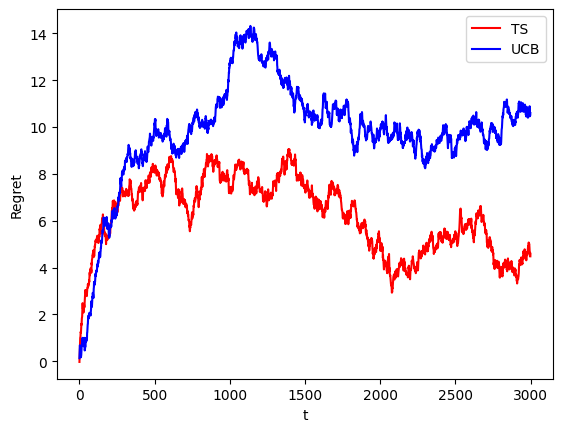

In [13]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - ts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - ucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["TS","UCB"])
plt.show()

In [10]:
ts_rewards_per_experiment

[array([0., 0., 1., ..., 0., 0., 1.]),
 array([1., 0., 0., ..., 1., 0., 1.]),
 array([1., 2., 1., ..., 1., 0., 2.]),
 array([0., 0., 1., ..., 1., 0., 1.]),
 array([0., 0., 0., ..., 1., 0., 1.]),
 array([2., 0., 1., ..., 1., 0., 1.]),
 array([1., 1., 1., ..., 1., 1., 0.]),
 array([0., 0., 0., ..., 0., 0., 2.]),
 array([1., 0., 0., ..., 1., 1., 2.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 2., 1., ..., 0., 0., 2.]),
 array([0., 0., 1., ..., 1., 1., 1.]),
 array([0., 2., 0., ..., 0., 1., 2.]),
 array([0., 0., 1., ..., 1., 2., 0.]),
 array([1., 0., 0., ..., 2., 0., 1.]),
 array([1., 2., 0., ..., 1., 1., 2.]),
 array([1., 1., 0., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([0., 1., 0., ..., 1., 0., 0.]),
 array([2., 0., 0., ..., 1., 0., 0.]),
 array([0., 0., 1., ..., 2., 1., 0.]),
 array([0., 2., 0., ..., 0., 1., 1.]),
 array([0., 0., 1., ..., 2., 0., 1.]),
 array([2., 0., 1., ..., 1., 0., 1.]),
 array([2., 0., 0., ..., 1., 2., 1.]),
 array([0., 0., 1., ..., 

Both the learners learn (curves are clearly below a linear line), and the TS is learns faster (mean cumulative regret lower when compared with UCB)